# Client de l'API Segmentation d'images routières

## Cellule 1 : prédictions sur données cityscapes locales 

image received. Processed in 0.7988513999999896 seconds. size=512x512


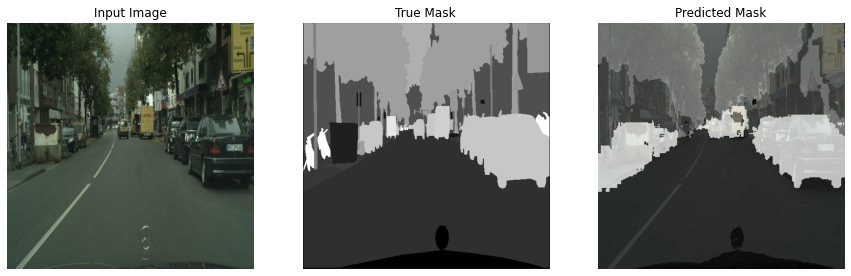

In [53]:
from __future__ import print_function
import os
import tensorflow as tf
import numpy as np
import random
import requests
import matplotlib.pyplot as plt
import json
import jsonpickle
import cv2
import io
from skimage.io import imread
from io import BytesIO
from tensorflow.keras.preprocessing import image


img_width=512
img_height=512

# Set data_folder path to your local folder containing the dataset to use images from Cityscapes
data_folder = 'C:\\Users\\Lewin\\Downloads\\OC\\Projet_8\\data\\'

# Set image index in validation library - if None, index will be picked randomly 
idx = None

# Below code creates lists of filepaths for both training and validation datasets 
train_img_ids = {}
val_img_ids = {}
train_img_list = []
val_img_list = []
train_mask_list = []
val_mask_list = []
for city in os.listdir(data_folder + 'leftImg8bit\\train'): 
    train_img_dir = data_folder + 'leftImg8bit\\train\\' + city + "\\"
    train_img_ids[city] = [n[8:-16] for n in os.listdir(train_img_dir)]
    for i in os.listdir(train_img_dir):
        train_img_list.append(train_img_dir + i)
    train_mask_dir = 'C:\\Users\\Lewin\\Downloads\\OC\\Projet_8\\data\\gtfine\\train\\' + city + "\\"
    for i in os.listdir(train_mask_dir):
        if "labelIds.png" in i:
            train_mask_list.append(train_mask_dir + i)

for city in os.listdir(data_folder + 'leftImg8bit\\val'):     
    val_img_dir = data_folder + 'leftImg8bit\\val\\' + city + "\\"
    val_img_ids[city] = [n[8:-16] for n in os.listdir(val_img_dir)]
    for i in os.listdir(val_img_dir):
        val_img_list.append(val_img_dir + i)
    val_mask_dir = 'C:\\Users\\Lewin\\Downloads\\OC\\Projet_8\\data\\gtfine\\val\\' + city + "\\"
    for i in os.listdir(val_mask_dir):
        if "labelIds.png" in i : 
            val_mask_list.append(val_mask_dir + i)          

# Random index will be used by loading functions if no specific index is provided
random_idx = random.randint(0,len(val_mask_list))  
            
def load_pic(idx = None): 
    if idx:
        pic = image.img_to_array(image.load_img(val_img_list[idx], target_size=(img_height,img_width)))
    else:
        pic = image.img_to_array(image.load_img(val_img_list[random_idx], target_size=(img_height,img_width)))
    return pic

def load_mask(idx = None):
    if idx:
        mask = image.img_to_array(image.load_img(val_mask_list[idx], target_size=(img_height,img_width)))
    else:
        mask = image.img_to_array(image.load_img(val_mask_list[random_idx], target_size=(img_height,img_width)))
    return mask

def bytes_to_ndarray(bytes):
        bytes_io = bytearray(bytes)
        read = imread(BytesIO(bytes_io))
        return np.array(read)

def display(display_list, titles = ['Input Image', 'True Mask', 'Blended Prediction']):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Set address here - localhost is kept as a comment since it still is used for any debug or improvement

addr = 'http://localhost:5000'
# addr = 'http://cityscapes-webapi.azurewebsites.net'
test_url = addr + '/simpleapi'

# Set target files here - only img will be sent for inference
idx = random_idx
img = image.array_to_img(load_pic(idx))
mask = image.array_to_img(load_mask(idx))

# prepare headers for http request
content_type = 'image/jpeg'
headers = {'content-type': content_type}

# Serialize image before posting 
buf = io.BytesIO()
img.save(buf, format='BMP')
byte_im = buf.getvalue()


# send http request with image and receive response
response = requests.post(test_url, data=byte_im, headers=headers)

# decode response
unpickled=jsonpickle.decode(response.text)
print(unpickled['message'])
nparr = bytes_to_ndarray(unpickled['annotated'])

# Display pictures : 
display([img, mask, nparr], ["Input Image","True Mask","Predicted Mask"])

## Cellule 2 : inférence sur une image locale hors dataset : 
Avec padding avant redimensionnement

image received. Processed in 4.57104398496449 seconds. size=512x512


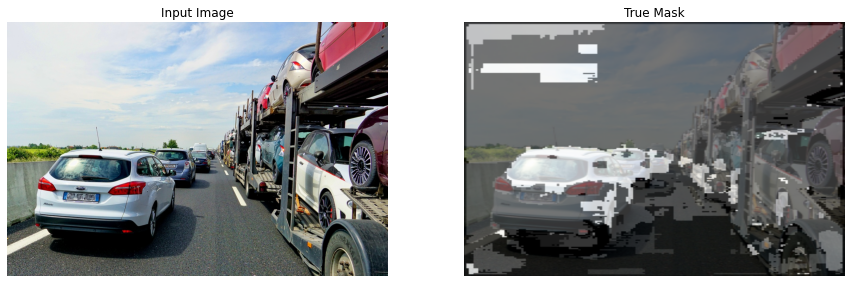

In [50]:
import os
import tensorflow as tf
import numpy as np
import requests
import matplotlib.pyplot as plt
import json
import jsonpickle
import cv2
import io
from skimage.io import imread
from io import BytesIO
from tensorflow.keras.preprocessing import image
from skimage.transform import resize



img_width=512
img_height=512

# Set data_folder path to your local folder containing the dataset to use images from Cityscapes
filepath = 'C:\\Users\\Lewin\\Downloads\\OC\\Projet_8\\photos_hors_dataset\\road-traffic-3417235_1280.jpg'


def bytes_to_ndarray(bytes):
        bytes_io = bytearray(bytes)
        read = imread(BytesIO(bytes_io))
        return np.array(read)

def display(display_list, titles = ['Blended Prediction']):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Set address here - localhost is kept as a comment since it still is used for any debug or improvement

# addr = 'http://localhost:5000'
addr = 'http://cityscapes-webapi.azurewebsites.net'
test_url = addr + '/api'

# Set target files here - only img will be sent for inference
img = image.load_img(filepath)
array = image.img_to_array(img)

actual_height, actual_width = array.shape[0], array.shape[1]
pad_width = 2048 - actual_width
pad_height = 1024 - actual_height

w_before = pad_width // 2
w_after = pad_width - w_before
h_before = pad_height // 2
h_after = pad_height - h_before

padded = np.pad(array, ((h_before,h_after),(w_before,w_after), (0,0)), mode='constant')
resized = resize(padded, (img_height, img_width))
resized = image.array_to_img(resized)

# prepare headers for http request
content_type = 'image/jpeg'
headers = {'content-type': content_type}

# Serialize image before posting 
buf = io.BytesIO()
resized.save(buf, format='BMP')
byte_im = buf.getvalue()

# send http request with image and receive response
response = requests.post(test_url, data=byte_im, headers=headers)

# decode response
unpickled=jsonpickle.decode(response.text)
print(unpickled['message'])
nparr = bytes_to_ndarray(unpickled['annotated'])
framed_mask = resize(nparr, (1024,2048), preserve_range=True)
framed_mask = framed_mask[h_before:-h_after,w_before:-w_after,:]

# Display pictures : 
display([img, framed_mask], ["Input Image","True Mask"])

## Cellule 3 : 0 données locales - envoi à l'API d'un index pour l'image et du ratio de blend

Processed in 1.9826554999999928 seconds. Image size=512x512


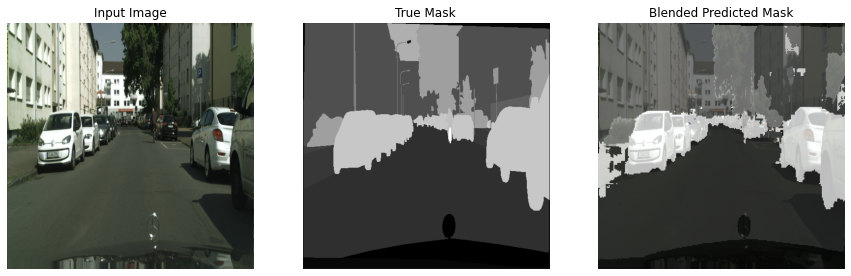

In [48]:
import os
import tensorflow as tf
import numpy as np
import random
import requests
import matplotlib.pyplot as plt
import json
import jsonpickle
import cv2
import io
from skimage.io import imread
from io import BytesIO
from tensorflow.keras.preprocessing import image
from skimage.transform import resize

image_index = 1
blend_ratio = 0.01

def bytes_to_ndarray(bytes):
        bytes_io = bytearray(bytes)
        read = imread(BytesIO(bytes_io))
        return np.array(read)

def display(display_list, titles = ['Blended Prediction']):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Set address here - localhost is kept as a comment since it still is used for any debug or improvement

addr = 'http://localhost:5000'
# addr = 'http://cityscapes-webapi.azurewebsites.net'
test_url = addr + '/theapi'



# prepare headers for http request
content_type = 'image/jpeg'
headers = {'content-type': content_type, 'index': str(image_index), 'alpha' : str(blend_ratio)}

# send http request with image and receive response
response = requests.post(test_url, data=byte_im, headers=headers)

# decode response
unpickled=jsonpickle.decode(response.text)
print(unpickled['message'])

annotated = bytes_to_ndarray(unpickled['content'][0])
ref_mask = bytes_to_ndarray(unpickled['content'][2])
original = bytes_to_ndarray(unpickled['content'][1])

# Display pictures : 
display([original, ref_mask, annotated], ["Input Image","True Mask", "Blended Predicted Mask"])